In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy.linalg import eigh
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import datetime
import joblib
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras import metrics as keras_metrics


<p style='font-size:18px'><b> 1) Final Cascade ensemble </b></p>

<p>

- Using the 3 layers of models trained so far, we will build a sequential cascading ensemble
- The probability threshold at each level for clearing points as 'not-fraud' will be variable to enable model tuning based on target metric (precison/recall/f1_score)

</p>    


In [2]:
# Load the dataset for credit card frauds
train_data = pd.read_csv('dataset/creditcard_train.csv')
test_data = pd.read_csv('dataset/creditcard_test.csv')

In [3]:
# Load all the finalised models in each level

# Level 1
l1_scaler = joblib.load('models/l1_scaler.pkl')
l1_rbf_svm = joblib.load('models/l1_rbfsvm_clf.pkl')
l1_prob_thresh = joblib.load('models/l1_prob_thresh.pkl')

# Level 2
l2_scaler = joblib.load('models/l2_scaler.pkl')
l2_nnmodel_clf = joblib.load('models/l2_nnmodel_clf.pkl')
l2_prob_thresh = joblib.load('models/l2_prob_thresh.pkl')

# Level 3
l3_scaler = joblib.load('models/l3_scaler.pkl')
l3_nnmodel_clf = joblib.load('models/l3_nnmodel_clf.pkl')
l3_prob_thresh = joblib.load('models/l3_prob_thresh.pkl')

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2024-06-30 20:48:18         2305
metadata.json                                  2024-06-30 20:48:18           64
variables.h5                                   2024-06-30 20:48:18      1008808
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive loading:
Fil

<p style='font-size:18px'><b> 2) Custom functions</b></p>



<p style='font-size:16px'><b> 2.1) Apply pipeline</b></p>

<p>

This functions represents the ensemble of 3 levels that we have built so far.

A) Inputs:
- Data: The 'X' datapoints corresponding to which the 'Y' class labels need to be predicted
- Prob threshold values: The threshold values for each level that the pipeline will use to clear points as 'not-fraud' corresponding to that level.
    
It uses the models that were built in each level & the input prob threshold values to return the following:

B) Output:    
- predict: The predicted class label of the data points.
- predict_proba: The prob of the the data points to be positive (class label 1)
- level_cleared: The level at which the datapoint was cleared as 'not-fraud' (between 1,2,3). If the datapoint doesn't clear all 3 levels (i.e it is predicted to be fraud) then the value is -1.

</p>    

<p style='font-size:16px'><b> 2.2) Performance report </b></p>

<p>

Function that takes input the actual class label, predicted class label, prob of prediction to generate a report of evaluation metrics like:
- Accuracy
- F1-score
- Recall
- Confusion matrix
</p>    

<p style='font-size:16px'><b> 2.3) Model comparison </b></p>

<p>

Function that takes input a list of probabilty threshold tuples each represent a different model & outputs multiple metrics on the data provided:
  
A) Inputs:
- Data: The data over which the performance will be computed & displayed for each model.
- List of Prob threshold values: List of tuples (of length 3), each tuple representing a unique model to be evaluated.
    
B Output:
Side by side comparison of all the provided models through the following metrics

- Total datapoints in input data
- True Positives
- False Negatives
- False Positives    
- Precision
- Recall
- F1score
- AUC score    
        
</p>    


In [31]:
def apply_pipeline(data, l1_prob_thresh, l2_prob_thresh, l3_prob_thresh):
    
    global l1_scaler, l1_rbf_svm, l2_scaler, l2_nnmodel_clf, l3_scaler, l3_nnmodel_clf
    
    # Following values to be calculated & returned:
    y_predict = np.ones((data.shape[0],), dtype = 'int')
    y_predict_proba = np.zeros((data.shape[0],), dtype = 'float')
    level_cleared = np.full((data.shape[0],), -1, dtype = 'int')
    
    # Applying level 1 model to entire input data
    data_l1_scaled = l1_scaler.transform(data)
    y_predict_proba = l1_rbf_svm.predict_proba(data_l1_scaled)[:,1]
    y_predict[(y_predict_proba<=l1_prob_thresh)] = 0
    level_cleared[(y_predict_proba<=l1_prob_thresh)] = 1
    
    # Applying level 2 model to points that didn't clear level 1 filter
    data_l2_scaled = l2_scaler.transform(data[(level_cleared == -1)])
    y_predict_proba[(level_cleared == -1)] = l2_nnmodel_clf.predict(data_l2_scaled, verbose=0).flatten()
    temp_proba = y_predict_proba[(level_cleared == -1)]
    y_predict[(level_cleared == -1)*(y_predict_proba<=l2_prob_thresh)] = 0
    level_cleared[(level_cleared == -1)*(y_predict_proba<=l2_prob_thresh)] = 2

    # Applying level 3 model to points that didn't clear level 2 filter
    data_l3_scaled = l3_scaler.transform(data[(level_cleared == -1)])
    y_predict_proba[(level_cleared == -1)] = l3_nnmodel_clf.predict(data_l3_scaled, verbose=0).flatten()
    temp_proba = y_predict_proba[(level_cleared == -1)]
    y_predict[(level_cleared == -1)*(y_predict_proba<=l3_prob_thresh)] = 0
    level_cleared[(level_cleared == -1)*(y_predict_proba<=l3_prob_thresh)] = 3
    
    # Return the calculated metrics as a pd dataframe    
    col = ['predict', 'predict_proba', 'level_cleared']
    calc_data = np.array([y_predict, y_predict_proba, level_cleared]).T
    calc_data_pd = pd.DataFrame(calc_data, columns=col)
    
    return calc_data_pd
    

In [5]:
def performance_report(y_actual, y_predict, y_pred_proba, header):
    
    # Get the unique labels that were to be predicted
    labels = np.unique(y_actual)
    
    print('\033[1m' + "\n--------- " + header + " ---------\n" + '\033[0m')
    
    # 1. Overall Accuracy
    acc = accuracy_score(y_actual, y_predict)
    print("1. Overall Accuracy: {}%".format(round(100*acc,1)))
    
    # 2. Label wise metrics
    perf_report = [['Label', 'Precision', 'Recall', 'F1-Score', 'True-P', 'False-N', 'False-P']]
    
    for label in labels:
        
        # Precision
        label_pred_mask = (y_predict == label)
        label_pred_match = (y_predict[label_pred_mask] == y_actual[label_pred_mask])
        prec = np.sum(label_pred_match)/label_pred_match.shape[0]
        
        # Recall
        label_act_mask = (y_actual == label)
        label_act_match = (y_predict[label_act_mask] == y_actual[label_act_mask])
        rec = np.sum(label_act_match)/label_act_match.shape[0]
        
        # F1-score
        f1_s = 2*prec*rec/(prec+rec)
        
        # Absolute counts
        true_p = np.sum(label_pred_match)
        false_n = label_act_match.shape[0] - np.sum(label_act_match)
        false_p = label_pred_match.shape[0] - np.sum(label_pred_match)
        
        perf_report.append([label, prec, rec, f1_s, true_p, false_n, false_p])
    
    # Macro averaged metrics
    temp_lbl = 'Macro-avg'
    temp_prec = precision_score(y_actual, y_predict, average='macro')
    temp_rec = recall_score(y_actual, y_predict, average='macro')
    temp_f1_score = f1_score(y_actual, y_predict, average='macro')
    perf_report.append([temp_lbl, temp_prec, temp_rec, temp_f1_score, '-', '-', '-'])
    print("2. Macro avg F1-score: {}%".format(round(100*temp_f1_score,1)))
    
    # Micro averaged metrics
    temp_lbl = 'Macro-avg'
    temp_prec = precision_score(y_actual, y_predict, average='micro')
    temp_rec = recall_score(y_actual, y_predict, average='micro')
    temp_f1_score = f1_score(y_actual, y_predict, average='micro')
    perf_report.append([temp_lbl, temp_prec, temp_rec, temp_f1_score, '-', '-', '-'])
    print("3. Micro avg F1-score: {}%".format(round(100*temp_f1_score,1)))
    
    # Auc score
    print("4. Auc score (for pos class): ", round(roc_auc_score(y_actual, y_pred_proba),3))
    
    # Label-wise metrics
    print("\n5. Label-wise Metrics:\n")
    col_width = 10
    print("".join(word.center(col_width) for word in perf_report[0]))
    print("-----------------------------------------------------------------")
    
    for row in perf_report[1:]:
        temp_lbl = str(row[0])
        temp_prec = str(round(100*row[1],1)) + '%'
        temp_rec = str(round(100*row[2],1)) + '%'
        temp_f1 = str(round(100*row[3],1)) + '%'
        
        print(temp_lbl.center(col_width), end = "")
        print(temp_prec.center(col_width), end = "")
        print(temp_rec.center(col_width), end = "")
        print(temp_f1.center(col_width), end = "")
        print(str(row[4]).center(col_width), end = "")
        print(str(row[5]).center(col_width), end = "")
        print(str(row[6]).center(col_width))
    
    print("\n6. Confusion matrix:\n")
    
    cm = confusion_matrix(y_actual, y_predict, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig = plt.figure(figsize = (4,4))
    axs = fig.subplots(1, 1)
    disp.plot(ax = axs, values_format = 'd')
    

In [42]:
def model_comparison(prob_thresholds, data_x, data_y, header):
    
    comparison_report = pd.DataFrame()
    comparison_report['Metrics'] = ['L1 prob thresh', 'L2 prob thresh', 'L3 prob thresh', 'Total datapts', 'True-P', 'False-N', 'False-P', 'Precision', 'Recall', 'F1-score', 'AUC score']
    
    print('\033[1m' + "\n--------- " + header + " ---------\n" + '\033[0m')
    
    for i in range(min(len(prob_thresholds), 15)):
        
        temp_report = []
        
        # Get the threshold values for each level as per this combination
        l1_prob_thresh = prob_thresholds[i][0]
        l2_prob_thresh = prob_thresholds[i][1]
        l3_prob_thresh = prob_thresholds[i][2]
        
        # Adding these threshold values to the report
        temp_report.append(str(round(100*l1_prob_thresh, 3)) + '%')
        temp_report.append(str(round(100*l2_prob_thresh, 3)) + '%')
        temp_report.append(str(round(100*l3_prob_thresh, 3)) + '%')
        
        # Total number of datapoints in the dataset
        temp_report.append(str(data_x.shape[0]))
        
        # Making the prediction using these threshold values
        multi_level_clf = apply_pipeline(data_x, l1_prob_thresh, l2_prob_thresh, l3_prob_thresh)
        y_pred = multi_level_clf.predict
        y_pred_proba = multi_level_clf.predict_proba
        
        # Calculating the absolute values of true positives, false negatives, false positives
        true_p = np.sum((data_y==1)&(data_y==y_pred))
        false_n = np.sum((data_y==1)&(data_y!=y_pred))
        false_p = np.sum((data_y==0)&(data_y!=y_pred))
        
        # Saving these absolute values to the report
        temp_report.append(str(true_p))
        temp_report.append(str(false_n))
        temp_report.append(str(false_p))
        
        # Calculating the % metrics like precision, recall, etc
        prec = true_p/(true_p + false_p)
        rec = true_p/(true_p + false_n)
        f1_scr = f1_score(data_y, y_pred)
        auc_sc = roc_auc_score(data_y, y_pred_proba)

        # Saving these metrics to the report
        temp_report.append(str(round(100*prec, 1)) + '%')
        temp_report.append(str(round(100*rec, 1)) + '%')
        temp_report.append(str(round(f1_scr, 3)))
        temp_report.append(str(round(auc_sc, 3)))
        
        # Saving final results to the comparison
        # Each 'combo' represents a unique model
        col_name = 'Combo' + str(i+1)
        comparison_report[col_name] = temp_report
        
#     print(comparison_report)
    return comparison_report


<p style='font-size:20px'><b> 3) Saved prob thresholds </b></p>

<p>

Applying the built ensemble using the prob thresholds saved during each modelling layers.

</p>

In [13]:
# Split into X (input) & Y (output)
train_x = train_data.drop(['Time', 'Class'], axis = 1).to_numpy()
train_y = train_data['Class'].to_numpy()

test_x = test_data.drop(['Time', 'Class'], axis = 1).to_numpy()
test_y = test_data['Class'].to_numpy()

52/52 [==============================] - 0s 949us/step
Run time (Train data):  0:00:22.750362

--------- Multi level clf: Train data ---------

1. Overall Accuracy: 100.0%
2. Macro avg F1-score: 96.4%
3. Micro avg F1-score: 100.0%
4. Auc score (for pos class):  0.998

5. Label-wise Metrics:

  Label   Precision   Recall   F1-Score   True-P   False-N   False-P  
-----------------------------------------------------------------
    0       100.0%    100.0%    100.0%    213191      41        15    
    1       89.7%     96.0%     92.7%      358        15        41    
Macro-avg   94.9%     98.0%     96.4%       -         -         -     
Macro-avg   100.0%    100.0%    100.0%      -         -         -     

6. Confusion matrix:



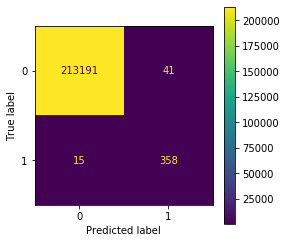

In [14]:
# Performance on training data
start_time = datetime.datetime.now()

multi_level_clf = apply_pipeline(train_x, l1_prob_thresh, l2_prob_thresh*2, l3_prob_thresh*10)
y_pred_train = multi_level_clf.predict
y_pred_proba_train = multi_level_clf.predict_proba

print("Run time (Train data): ", datetime.datetime.now() - start_time)

performance_report(train_y, y_pred_train, y_pred_proba_train, 'Multi level clf: Train data')

17/17 [==============================] - 0s 1ms/step
Run time (test data):  0:00:07.395873

--------- Multi level clf: test data ---------

1. Overall Accuracy: 99.9%
2. Macro avg F1-score: 90.0%
3. Micro avg F1-score: 99.9%
4. Auc score (for pos class):  0.897

5. Label-wise Metrics:

  Label   Precision   Recall   F1-Score   True-P   False-N   False-P  
-----------------------------------------------------------------
    0       100.0%    100.0%    100.0%    71058       25        23    
    1       79.3%     80.7%     80.0%       96        23        25    
Macro-avg   89.7%     90.3%     90.0%       -         -         -     
Macro-avg   99.9%     99.9%     99.9%       -         -         -     

6. Confusion matrix:



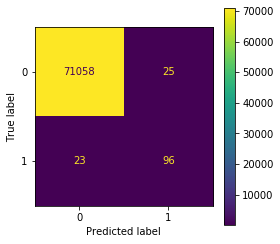

In [15]:
# Performance on testing data
start_time = datetime.datetime.now()

multi_level_clf = apply_pipeline(test_x, l1_prob_thresh, l2_prob_thresh*2, l3_prob_thresh*10)
y_pred_test = multi_level_clf.predict
y_pred_proba_test = multi_level_clf.predict_proba

print("Run time (test data): ", datetime.datetime.now() - start_time)

performance_report(test_y, y_pred_test, y_pred_proba_test, 'Multi level clf: test data')


<p style='font-size:20px'><b> 3) Model tuning </b></p>

<p>

As discussed during EDA, we will now experiment with the thresholds and tune the model for different business requirements:
- Case 1) High recall, i.e minimum False-negatives.
- Case 2) High precision , i.e minimum False-positives.
- Case 3) A balance between Case 1 & Case 2 - F1 score, AUC score should be high (the targe metric mentioned on kaggle)    
    
</p>


<p style='font-size:16px'><b> 3.1.1) High recall models </b></p>

<p>

- For higher recall, we will have to reduce our probability thresholds so that the models in each layer filter out only the datapoints having extremely low probability of being 'fraud'.
- This reduction has been enabled by multiplying the saved prob thresholds by a factor in 13 different combinations each representing a unique model.
    
</p>


In [52]:
prob_thresholds = \
[(0.5*l1_prob_thresh, 0.5*l2_prob_thresh, 0.5*l3_prob_thresh), \
(0.5*l1_prob_thresh, 0.5*l2_prob_thresh, 0.75*l3_prob_thresh), \
(0.5*l1_prob_thresh, 0.75*l2_prob_thresh, 0.75*l3_prob_thresh), \
(0.75*l1_prob_thresh, 0.75*l2_prob_thresh, 0.75*l3_prob_thresh), \
(0.75*l1_prob_thresh, 0.75*l2_prob_thresh, 0.9*l3_prob_thresh), \
(0.75*l1_prob_thresh, 0.9*l2_prob_thresh, 0.9*l3_prob_thresh), \
(0.9*l1_prob_thresh, 0.9*l2_prob_thresh, 0.9*l3_prob_thresh), \
(0.75*l1_prob_thresh, 0.75*l2_prob_thresh, 2.5*l3_prob_thresh), \
(0.75*l1_prob_thresh, 0.75*l2_prob_thresh, 5*l3_prob_thresh), \
(1.5*l1_prob_thresh, 0.75*l2_prob_thresh, 0.75*l3_prob_thresh), \
(0.75*l1_prob_thresh, 2*l2_prob_thresh, 0.75*l3_prob_thresh), \
(0.75*l1_prob_thresh, 2*l2_prob_thresh, 1.5*l3_prob_thresh), \
(1*l1_prob_thresh, 1*l2_prob_thresh, 1*l3_prob_thresh)]

In [53]:
model_comparison(prob_thresholds, train_x, train_y, 'High recall solution: Train data')


--------- High recall solution: Train data ---------



,Metrics,Combo1,Combo2,Combo3,Combo4,Combo5,Combo6,Combo7,Combo8,Combo9,Combo10,Combo11,Combo12,Combo13
0,L1 prob thresh,0.095%,0.095%,0.095%,0.143%,0.143%,0.143%,0.172%,0.143%,0.143%,0.286%,0.143%,0.143%,0.191%
1,L2 prob thresh,0.014%,0.014%,0.021%,0.021%,0.021%,0.025%,0.025%,0.021%,0.021%,0.021%,0.055%,0.055%,0.027%
2,L3 prob thresh,0.601%,0.901%,0.901%,0.901%,1.081%,1.081%,1.081%,3.004%,6.008%,0.901%,0.901%,1.802%,1.202%
3,Total datapts,213605,213605,213605,213605,213605,213605,213605,213605,213605,213605,213605,213605,213605
4,True-P,373,373,373,373,373,373,373,371,365,372,372,370,373
5,False-N,0,0,0,0,0,0,0,2,8,1,1,3,0
6,False-P,3014,2224,1741,1525,1311,1163,1068,447,186,754,813,447,852
7,Precision,11.0%,14.4%,17.6%,19.7%,22.1%,24.3%,25.9%,45.4%,66.2%,33.0%,31.4%,45.3%,30.4%
8,Recall,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,99.5%,97.9%,99.7%,99.7%,99.2%,100.0%
9,F1-score,0.198,0.251,0.3,0.328,0.363,0.391,0.411,0.623,0.79,0.496,0.478,0.622,0.467


In [54]:
model_comparison(prob_thresholds, test_x, test_y, 'High recall solution: Test data')


--------- High recall solution: Test data ---------



,Metrics,Combo1,Combo2,Combo3,Combo4,Combo5,Combo6,Combo7,Combo8,Combo9,Combo10,Combo11,Combo12,Combo13
0,L1 prob thresh,0.095%,0.095%,0.095%,0.143%,0.143%,0.143%,0.172%,0.143%,0.143%,0.286%,0.143%,0.143%,0.191%
1,L2 prob thresh,0.014%,0.014%,0.021%,0.021%,0.021%,0.025%,0.025%,0.021%,0.021%,0.021%,0.055%,0.055%,0.027%
2,L3 prob thresh,0.601%,0.901%,0.901%,0.901%,1.081%,1.081%,1.081%,3.004%,6.008%,0.901%,0.901%,1.802%,1.202%
3,Total datapts,71202,71202,71202,71202,71202,71202,71202,71202,71202,71202,71202,71202,71202
4,True-P,103,103,103,103,103,102,102,100,99,101,101,100,100
5,False-N,16,16,16,16,16,17,17,19,20,18,18,19,19
6,False-P,999,750,589,531,450,402,371,182,90,285,302,179,304
7,Precision,9.3%,12.1%,14.9%,16.2%,18.6%,20.2%,21.6%,35.5%,52.4%,26.2%,25.1%,35.8%,24.8%
8,Recall,86.6%,86.6%,86.6%,86.6%,86.6%,85.7%,85.7%,84.0%,83.2%,84.9%,84.9%,84.0%,84.0%
9,F1-score,0.169,0.212,0.254,0.274,0.307,0.327,0.345,0.499,0.643,0.4,0.387,0.503,0.382


<p style='font-size:16px'><b> 3.1.2) High recall models - performance </b></p>

<p>

- From the above comparison of models, all models output a high recall in both train & test data.
- However, the models represented by Combo 7,8,9 are able to do so while maintaining relatively the highest amount of precision.

</p>


<p style='font-size:16px'><b> 3.2.1) High Precision models </b></p>

<p>

- For higher precision, we will have to increase our probability thresholds so that the models in each layer pass on only the datapoints having high probability of being 'fraud' to the next layer.
- This increase too has been enabled by multiplying the saved prob thresholds by a factor in 13 different combinations each representing a unique model.
    
</p>


In [69]:
prob_thresholds = \
[(30*l1_prob_thresh, 500*l2_prob_thresh, 10*l3_prob_thresh), \
(30*l1_prob_thresh, 500*l2_prob_thresh, 30*l3_prob_thresh), \
(30*l1_prob_thresh, 500*l2_prob_thresh, 50*l3_prob_thresh), \
(30*l1_prob_thresh, 500*l2_prob_thresh, 70*l3_prob_thresh), \
(120*l1_prob_thresh, 1000*l2_prob_thresh, 10*l3_prob_thresh), \
(120*l1_prob_thresh, 1000*l2_prob_thresh, 30*l3_prob_thresh), \
(120*l1_prob_thresh, 1000*l2_prob_thresh, 50*l3_prob_thresh), \
(120*l1_prob_thresh, 1000*l2_prob_thresh, 70*l3_prob_thresh), \
(250*l1_prob_thresh, 2500*l2_prob_thresh, 10*l3_prob_thresh), \
(250*l1_prob_thresh, 2500*l2_prob_thresh, 30*l3_prob_thresh), \
(250*l1_prob_thresh, 2500*l2_prob_thresh, 50*l3_prob_thresh), \
(250*l1_prob_thresh, 2500*l2_prob_thresh, 70*l3_prob_thresh), \
(1*l1_prob_thresh, 1*l2_prob_thresh, 1*l3_prob_thresh)]

In [70]:
model_comparison(prob_thresholds, train_x, train_y, 'High Precision solution: Train data')


--------- High Precision solution: Train data ---------



,Metrics,Combo1,Combo2,Combo3,Combo4,Combo5,Combo6,Combo7,Combo8,Combo9,Combo10,Combo11,Combo12,Combo13
0,L1 prob thresh,5.718%,5.718%,5.718%,5.718%,22.873%,22.873%,22.873%,22.873%,47.652%,47.652%,47.652%,47.652%,0.191%
1,L2 prob thresh,13.718%,13.718%,13.718%,13.718%,27.435%,27.435%,27.435%,27.435%,68.589%,68.589%,68.589%,68.589%,0.027%
2,L3 prob thresh,12.015%,36.045%,60.075%,84.105%,12.015%,36.045%,60.075%,84.105%,12.015%,36.045%,60.075%,84.105%,1.202%
3,Total datapts,213605,213605,213605,213605,213605,213605,213605,213605,213605,213605,213605,213605,213605
4,True-P,340,339,334,318,331,330,326,315,322,322,318,309,373
5,False-N,33,34,39,55,42,43,47,58,51,51,55,64,0
6,False-P,4,1,0,0,3,1,0,0,2,1,0,0,852
7,Precision,98.8%,99.7%,100.0%,100.0%,99.1%,99.7%,100.0%,100.0%,99.4%,99.7%,100.0%,100.0%,30.4%
8,Recall,91.2%,90.9%,89.5%,85.3%,88.7%,88.5%,87.4%,84.5%,86.3%,86.3%,85.3%,82.8%,100.0%
9,F1-score,0.948,0.951,0.945,0.92,0.936,0.938,0.933,0.916,0.924,0.925,0.92,0.906,0.467


In [71]:
model_comparison(prob_thresholds, test_x, test_y, 'High Precision solution: Test data')


--------- High Precision solution: Test data ---------



,Metrics,Combo1,Combo2,Combo3,Combo4,Combo5,Combo6,Combo7,Combo8,Combo9,Combo10,Combo11,Combo12,Combo13
0,L1 prob thresh,5.718%,5.718%,5.718%,5.718%,22.873%,22.873%,22.873%,22.873%,47.652%,47.652%,47.652%,47.652%,0.191%
1,L2 prob thresh,13.718%,13.718%,13.718%,13.718%,27.435%,27.435%,27.435%,27.435%,68.589%,68.589%,68.589%,68.589%,0.027%
2,L3 prob thresh,12.015%,36.045%,60.075%,84.105%,12.015%,36.045%,60.075%,84.105%,12.015%,36.045%,60.075%,84.105%,1.202%
3,Total datapts,71202,71202,71202,71202,71202,71202,71202,71202,71202,71202,71202,71202,71202
4,True-P,84,84,84,79,83,83,83,78,78,78,78,75,100
5,False-N,35,35,35,40,36,36,36,41,41,41,41,44,19
6,False-P,7,5,5,4,4,3,3,2,3,2,2,1,304
7,Precision,92.3%,94.4%,94.4%,95.2%,95.4%,96.5%,96.5%,97.5%,96.3%,97.5%,97.5%,98.7%,24.8%
8,Recall,70.6%,70.6%,70.6%,66.4%,69.7%,69.7%,69.7%,65.5%,65.5%,65.5%,65.5%,63.0%,84.0%
9,F1-score,0.8,0.808,0.808,0.782,0.806,0.81,0.81,0.784,0.78,0.784,0.784,0.769,0.382


<p style='font-size:16px'><b> 3.2.2) High precision models - performance </b></p>

<p>

- Here too, from the above comparison, most of the models have a high precision above 95%.
- However, relatively, the combo 6 & 7 also have a high recall.
- And the models 11, 12 have the highest precision with a slightly lesser recall.

</p>


<p style='font-size:16px'><b> 3.3.1) Balanced models </b></p>

<p>

Here, we will tune the prob threshold values with the goal of maximising F1 score & AUC score i.e giving equal priority to precision & recall.

</p>


In [72]:
prob_thresholds = \
[(0.75*l1_prob_thresh, 0.75*l2_prob_thresh, 1*l3_prob_thresh), \
(0.75*l1_prob_thresh, 1*l2_prob_thresh, 30*l3_prob_thresh), \
(0.75*l1_prob_thresh, 500*l2_prob_thresh, 50*l3_prob_thresh), \
(1*l1_prob_thresh, 0.75*l2_prob_thresh, 1*l3_prob_thresh), \
(1*l1_prob_thresh, 1*l2_prob_thresh, 30*l3_prob_thresh), \
(1*l1_prob_thresh, 500*l2_prob_thresh, 50*l3_prob_thresh), \
(10*l1_prob_thresh, 0.75*l2_prob_thresh, 1*l3_prob_thresh), \
(10*l1_prob_thresh, 1*l2_prob_thresh, 30*l3_prob_thresh), \
(10*l1_prob_thresh, 500*l2_prob_thresh, 50*l3_prob_thresh), \
(30*l1_prob_thresh, 0.75*l2_prob_thresh, 1*l3_prob_thresh), \
(30*l1_prob_thresh, 1*l2_prob_thresh, 30*l3_prob_thresh), \
(30*l1_prob_thresh, 500*l2_prob_thresh, 50*l3_prob_thresh), \
(1*l1_prob_thresh, 1*l2_prob_thresh, 1*l3_prob_thresh)]

In [73]:
model_comparison(prob_thresholds, train_x, train_y, 'Balanced solution: Train data')


--------- Balanced solution: Train data ---------



,Metrics,Combo1,Combo2,Combo3,Combo4,Combo5,Combo6,Combo7,Combo8,Combo9,Combo10,Combo11,Combo12,Combo13
0,L1 prob thresh,0.143%,0.143%,0.143%,0.191%,0.191%,0.191%,1.906%,1.906%,1.906%,5.718%,5.718%,5.718%,0.191%
1,L2 prob thresh,0.021%,0.027%,13.718%,0.021%,0.027%,13.718%,0.021%,0.027%,13.718%,0.021%,0.027%,13.718%,0.027%
2,L3 prob thresh,1.202%,36.045%,60.075%,1.202%,36.045%,60.075%,1.202%,36.045%,60.075%,1.202%,36.045%,60.075%,1.202%
3,Total datapts,213605,213605,213605,213605,213605,213605,213605,213605,213605,213605,213605,213605,213605
4,True-P,373,352,341,373,352,341,348,345,337,343,341,334,373
5,False-N,0,21,32,0,21,32,25,28,36,30,32,39,0
6,False-P,1181,2,0,1008,2,0,27,1,0,22,1,0,852
7,Precision,24.0%,99.4%,100.0%,27.0%,99.4%,100.0%,92.8%,99.7%,100.0%,94.0%,99.7%,100.0%,30.4%
8,Recall,100.0%,94.4%,91.4%,100.0%,94.4%,91.4%,93.3%,92.5%,90.3%,92.0%,91.4%,89.5%,100.0%
9,F1-score,0.387,0.968,0.955,0.425,0.968,0.955,0.93,0.96,0.949,0.93,0.954,0.945,0.467


In [74]:
model_comparison(prob_thresholds, test_x, test_y, 'Balanced solution: Test data')


--------- Balanced solution: Test data ---------



,Metrics,Combo1,Combo2,Combo3,Combo4,Combo5,Combo6,Combo7,Combo8,Combo9,Combo10,Combo11,Combo12,Combo13
0,L1 prob thresh,0.143%,0.143%,0.143%,0.191%,0.191%,0.191%,1.906%,1.906%,1.906%,5.718%,5.718%,5.718%,0.191%
1,L2 prob thresh,0.021%,0.027%,13.718%,0.021%,0.027%,13.718%,0.021%,0.027%,13.718%,0.021%,0.027%,13.718%,0.027%
2,L3 prob thresh,1.202%,36.045%,60.075%,1.202%,36.045%,60.075%,1.202%,36.045%,60.075%,1.202%,36.045%,60.075%,1.202%
3,Total datapts,71202,71202,71202,71202,71202,71202,71202,71202,71202,71202,71202,71202,71202
4,True-P,103,94,94,101,94,94,96,92,92,86,84,84,100
5,False-N,16,25,25,18,25,25,23,27,27,33,35,35,19
6,False-P,416,18,8,359,16,8,21,8,7,10,5,5,304
7,Precision,19.8%,83.9%,92.2%,22.0%,85.5%,92.2%,82.1%,92.0%,92.9%,89.6%,94.4%,94.4%,24.8%
8,Recall,86.6%,79.0%,79.0%,84.9%,79.0%,79.0%,80.7%,77.3%,77.3%,72.3%,70.6%,70.6%,84.0%
9,F1-score,0.323,0.814,0.851,0.349,0.821,0.851,0.814,0.84,0.844,0.8,0.808,0.808,0.382


<p style='font-size:16px'><b> 3.3.2) Balanced models - performance </b></p>

<p>

The models represented by combo 7,8,9 were able to achieve the highest F1-score & AUc score compared to other models 

</p>


<p style='font-size:16px'><b> 4.1) Overall summary </b></p>

<p>

Capturing the best models from above thress cases & re-visualizing them as mentioned below:

Combo 1,2,3 - High recall    
Combo 4,5,6 - Balanced    
Combo 7,8,9 - High precision


</p>


In [76]:
prob_thresholds = \
[(0.9*l1_prob_thresh, 0.9*l2_prob_thresh, 0.5*l3_prob_thresh), \
(0.9*l1_prob_thresh, 0.9*l2_prob_thresh, 0.75*l3_prob_thresh), \
(1*l1_prob_thresh, 1*l2_prob_thresh, 1*l3_prob_thresh), \
(10*l1_prob_thresh, 0.75*l2_prob_thresh, 1*l3_prob_thresh), \
(10*l1_prob_thresh, 1*l2_prob_thresh, 30*l3_prob_thresh), \
(10*l1_prob_thresh, 500*l2_prob_thresh, 50*l3_prob_thresh), \
(120*l1_prob_thresh, 1000*l2_prob_thresh, 30*l3_prob_thresh), \
(250*l1_prob_thresh, 2500*l2_prob_thresh, 50*l3_prob_thresh), \
(250*l1_prob_thresh, 2500*l2_prob_thresh, 70*l3_prob_thresh)]

In [77]:
model_comparison(prob_thresholds, train_x, train_y, 'Overall summary: Train data')


--------- Overall summary: Train data ---------



,Metrics,Combo1,Combo2,Combo3,Combo4,Combo5,Combo6,Combo7,Combo8,Combo9
0,L1 prob thresh,0.172%,0.172%,0.191%,1.906%,1.906%,1.906%,22.873%,47.652%,47.652%
1,L2 prob thresh,0.025%,0.025%,0.027%,0.021%,0.027%,13.718%,27.435%,68.589%,68.589%
2,L3 prob thresh,0.601%,0.901%,1.202%,1.202%,36.045%,60.075%,36.045%,60.075%,84.105%
3,Total datapts,213605,213605,213605,213605,213605,213605,213605,213605,213605
4,True-P,373,373,373,348,345,337,330,318,309
5,False-N,0,0,0,25,28,36,43,55,64
6,False-P,1617,1239,852,27,1,0,1,0,0
7,Precision,18.7%,23.1%,30.4%,92.8%,99.7%,100.0%,99.7%,100.0%,100.0%
8,Recall,100.0%,100.0%,100.0%,93.3%,92.5%,90.3%,88.5%,85.3%,82.8%
9,F1-score,0.316,0.376,0.467,0.93,0.96,0.949,0.938,0.92,0.906


In [78]:
model_comparison(prob_thresholds, test_x, test_y, 'Overall summary: Test data')


--------- Overall summary: Test data ---------



,Metrics,Combo1,Combo2,Combo3,Combo4,Combo5,Combo6,Combo7,Combo8,Combo9
0,L1 prob thresh,0.172%,0.172%,0.191%,1.906%,1.906%,1.906%,22.873%,47.652%,47.652%
1,L2 prob thresh,0.025%,0.025%,0.027%,0.021%,0.027%,13.718%,27.435%,68.589%,68.589%
2,L3 prob thresh,0.601%,0.901%,1.202%,1.202%,36.045%,60.075%,36.045%,60.075%,84.105%
3,Total datapts,71202,71202,71202,71202,71202,71202,71202,71202,71202
4,True-P,102,102,100,96,92,92,83,78,75
5,False-N,17,17,19,23,27,27,36,41,44
6,False-P,553,437,304,21,8,7,3,2,1
7,Precision,15.6%,18.9%,24.8%,82.1%,92.0%,92.9%,96.5%,97.5%,98.7%
8,Recall,85.7%,85.7%,84.0%,80.7%,77.3%,77.3%,69.7%,65.5%,63.0%
9,F1-score,0.264,0.31,0.382,0.814,0.84,0.844,0.81,0.784,0.769


<p style='font-size:16px'><b> 4.2) Final performance </b></p>

<p>

Following is the performance of the best models on test data:
    
A) High recall
    
- Precision: 24.8%
- Recall: 84%
- F1-score: 0.382
- AUC score: 0.896    

    
B) Balanced

- Precision: 92.9%
- Recall: 77.3%
- F1-score: 0.844
- AUC score: 0.945
    
    
A) High recall

- Precision: 98.7%
- Recall: 63%
- F1-score: 0.769
- AUC score: 0.945
    
</p>
